# Ridge regression model for the king country houses dataset

In [1]:
# 📚 Basic Libraries
import pandas as pd
import numpy as np
import pickle
import os

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

# 🤖 Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
data = pd.read_csv(r"dataset\king_country_houses_aa.csv")
df = data.copy()
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [3]:
# moving price to the end of dataframe
target = 'price'
cols = list(df.columns)
cols.remove(target)
df = df[cols + [target]]
df.head(3)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900.0
1,6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000.0
2,5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000.0


In [4]:
# copy from main
continuous_columns = []
continuous_columns.append('price')
continuous_columns.append('sqft_lot')
continuous_columns.append('sqft_lot15')
continuous_columns.append('sqft_above')
continuous_columns.append('sqft_basement')
continuous_columns.append('sqft_living')
continuous_columns.append('lat')
continuous_columns.append('long')
continuous_columns

discrete_columns = []
discrete_columns.append('price')
discrete_columns.append('view')
discrete_columns.append('bedrooms')
discrete_columns.append('bathrooms')
discrete_columns.append('floors')
discrete_columns.append('zipcode')
discrete_columns.append('yr_built')
discrete_columns.append('yr_renovated')
discrete_columns

num_total = []
num_total.append('sqft_lot')
num_total.append('sqft_lot15')
num_total.append('sqft_above')
num_total.append('sqft_basement')
num_total.append('sqft_living')
num_total.append('lat')
num_total.append('long')
num_total.append('view')
num_total.append('bedrooms')
num_total.append('bathrooms')
num_total.append('floors')
num_total.append('zipcode')
# num_total.append('yr_built')
# num_total.append('yr_renovated')
num_total.append('price')

### Correlation of numeric continous features with price(target)

In [5]:
df[num_total].corr()["price"].sort_values(ascending=True)

zipcode         -0.053203
long             0.021626
sqft_lot15       0.082447
sqft_lot         0.089661
floors           0.256794
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_above       0.605567
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

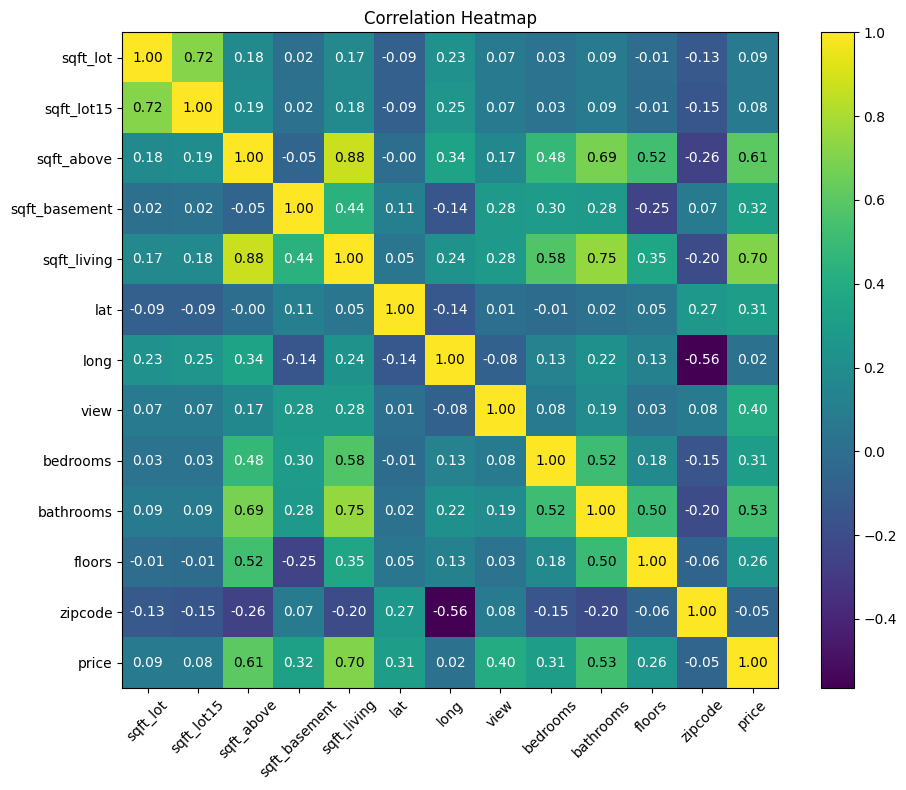

In [6]:
corr_matrix = df[num_total].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()

# set tick marks and labels
tick_marks = np.arange(len(corr_matrix.columns))
plt.xticks(tick_marks, corr_matrix.columns, rotation=45)
plt.yticks(tick_marks, corr_matrix.columns)

# add text annotations for each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if corr_matrix.iloc[i, j] < 0.5 else 'black')

plt.tight_layout()
plt.show()


## 1. Focus: Ridge regression - baseline model
1.1 Defining the features and target.

In [7]:
features = num_total
target = 'price'

X = df[features].drop(columns="price", axis=1)
y = df[target]

1.2. Split the dataset into training and testing sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1.3. Create a pipeline that scales the data then applies Ridge Regression.

In [9]:
pipeline = make_pipeline(StandardScaler(), Ridge())

1.4. Set up a grid search to find the best alpha (lambda in math (regularization strength)).

In [10]:
# alpha controls the amount of shrinkage: higher alpha -> more regularization
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

ridge_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

1.5. Evaluate the model on both training and testing data.

Train R2 Score: 0.633018076200857
Test R2 Score: 0.6329565249432942
Train MSE: 47945679616.52844
Test MSE: 55488425814.40433


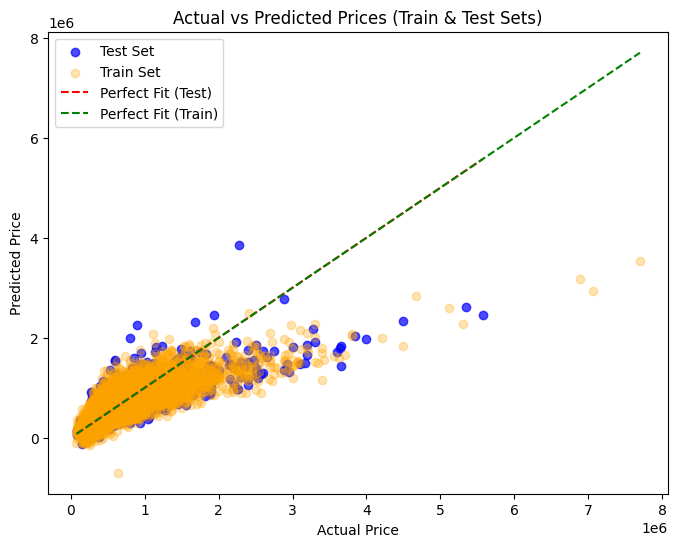

In [11]:
# get predictions
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# Print metrics
print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# plot Actual vs Predicted prices for both sets
plt.figure(figsize=(8,6))

# scatter plot for test set
plt.scatter(y_test, y_test_pred, alpha=0.7, label="Test Set", color="blue")

# scatter plot for training set
plt.scatter(y_train, y_train_pred, alpha=0.3, label="Train Set", color="orange")

# add reference lines
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (Test)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'g--', label="Perfect Fit (Train)")

# labels and legend
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Train & Test Sets)")
plt.legend()
plt.show()


## 2. Focus: Ridge regression - calibration
### 2.2 Defining the features and target. Passing the features with the lowest intercorrelation and highest correlation with the target(threshold - adjustable)

In [12]:
# function to control the noise level - before applying make sure none of correlations returns NaN
def noise_control(df: pd.DataFrame, n: float, m: float):
    mute_list = []
    target = df.columns[-1]  # the last column is the target

    # ensure target is numeric
    if not pd.api.types.is_numeric_dtype(df[target]):
        raise ValueError("Target column must be numeric for correlation computation.")

    for i in df.columns:
        # skip if the current column is the target column
        if i == target:
            continue
        # skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(df[i]):
            continue

        corr_with_target = df[i].corr(df[target])
        # print(f"Correlation between {i} and target: {corr_with_target}")  # debug print

        if corr_with_target > n:
            for j in df.columns:
                if i == j:
                    continue  # Skip self-correlation
                if not pd.api.types.is_numeric_dtype(df[j]):
                    continue
                corr_with_j = df[i].corr(df[j])
                # print(f"  Correlation between {i} and {j}: {corr_with_j}")  # debug print

                if corr_with_j < m:
                    mute_list.append(i)
                    break  # prevent duplicate additions
    return mute_list


noise_control(df :  pandas dataframe, n: float( feature to target correlation leftside threshold), m: float( feature-to-feature correlation right side threshold) )

### 2.2 Conversion of all steps used in the baseline model into a function, plus integrated noise_control function

In [13]:
def run_model_pipeline(df: pd.DataFrame, noise_n: float, noise_m: float, alpha: float, target: str = 'price'):
    """
    Runs a Ridge Regression model with different noise and alpha values.
    
    Parameters:
      df      : pandas DataFrame with data.
      noise_n : Threshold for correlation between features and the target.
      noise_m : Threshold for correlation between features.
      alpha   : Ridge regularization parameter.
      target  : The name of the target column (default 'price').
    
    Returns:
      A dictionary containing model results.
    """
    # call the noise_control function to get the list of features (mute_list)
    mute_list = noise_control(df, n=noise_n, m=noise_m)
    
    # ensure target is not in feature list
    features = mute_list.copy()
    if target in features:
        features.remove(target)

    # create feature matrix X and target vector y
    X = df[features]
    y = df[target]

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # build a pipeline with a StandardScaler and Ridge Regression with the given alpha
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=alpha))

    # fit the model
    pipeline.fit(X_train, y_train)

    # get predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # compute R² scores
    best_r2_train = pipeline.score(X_train, y_train)
    best_r2_test = pipeline.score(X_test, y_test)

    # compute Mean Squared Error (MSE)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # compute Mean Absolute Error (MAE)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # compile results in a dictionary
    results = {
        "best_r2_train": best_r2_train,
        "best_r2_test": best_r2_test,
        "mse_train": mse_train,
        "mse_test": mse_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
        "train_predictions": y_train_pred,
        "test_predictions": y_test_pred,
        "y_test_actual": y_test,  # Add actual test values
        "features_used": features,
    }
    
    return results


Example usage of the run_model_pipeline function

In [14]:
# results_dict = run_model_pipeline(df, noise_n=0.5, noise_m=0.5, target='price')
# print(results_dict)

# print()

# results_dict = run_model_pipeline(df, noise_n=0.3, noise_m=0.5, target='price')
# print(results_dict)

print()

results_dict = run_model_pipeline(df, noise_n=0.1, noise_m=0.5, alpha=0.1, target='price')
print(results_dict)

print()

results_dict = run_model_pipeline(df, noise_n=0.01, noise_m=0.3, alpha=0.01, target='price')
print(results_dict)



{'best_r2_train': 0.6607580835150254, 'best_r2_test': 0.6643981550336536, 'mse_train': 44321486115.45229, 'mse_test': 50735183549.347534, 'mae_train': 133010.76976445605, 'mae_test': 136844.39496727235, 'train_predictions': array([468171.42874104, 213559.1262609 , 144367.48563534, ...,
       540588.45977681,  -9396.81096654, 520953.10139031], shape=(17290,)), 'test_predictions': array([ 432820.11199594,  753510.09917589, 1225020.58235776, ...,
        401300.22712577,  598397.46135241,  422892.75479009],
      shape=(4323,)), 'y_test_actual': 735       365000.0
2830      865000.0
4106     1038000.0
16218    1490000.0
19964     711000.0
           ...    
13674     338000.0
20377     673000.0
8805      285000.0
10168     605000.0
2522      356500.0
Name: price, Length: 4323, dtype: float64, 'features_used': ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15']}

{'best_r2_train': 0.69510

External function

In [15]:
# Function from Annie for the project cohesiveness
def model_validation(results_df, final_model):
    """
    The function `model_validation` generates various diagnostic plots and learning/validation curves
    for evaluating a regression model's performance.
    
    Parameters:
        - results_df: The `results_df` parameter is a DataFrame containing the following columns: 
                    ["Actual Price", "Predicted Price", "Difference"]. 
        - final_model: The trained machine learning model that you want to evaluate and validate. 
    """

    y_actual = results_df['Actual Price']  
    y_pred = results_df['Predicted Price']
    residuals = results_df['Difference']

    # 1. Actual vs. Predicted Values
    plt.figure(figsize=(8, 6))
    sns.regplot(x='Actual Price', y='Predicted Price', data=results_df,
                scatter_kws={"color": "blue", "alpha": 0.5},
                line_kws={"color": "red", "linewidth": 3},
                ci=100)
    plt.ylim(bottom=0)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual')
    plt.ylabel('Predictions')
    plt.show()

    # 2. Residuals vs. Predicted Values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted Values")
    plt.show()

    # 3. Histogram of Residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=60, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Distribution of Residuals")
    plt.show()

    # 4. Q-Q Plot to check normality of residuals
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.show()

## The Main Script
### 🚀 Run & 🥒 Save 

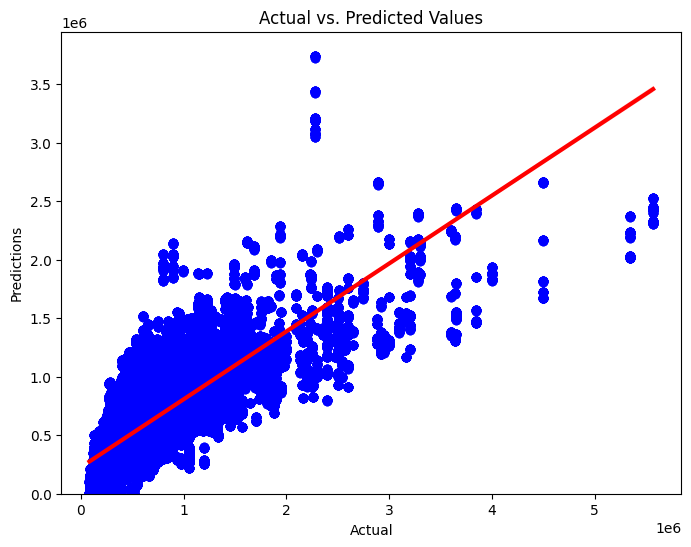

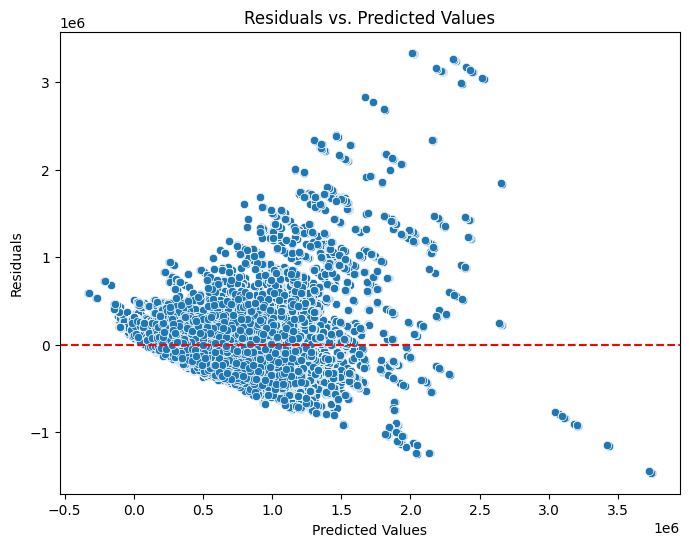

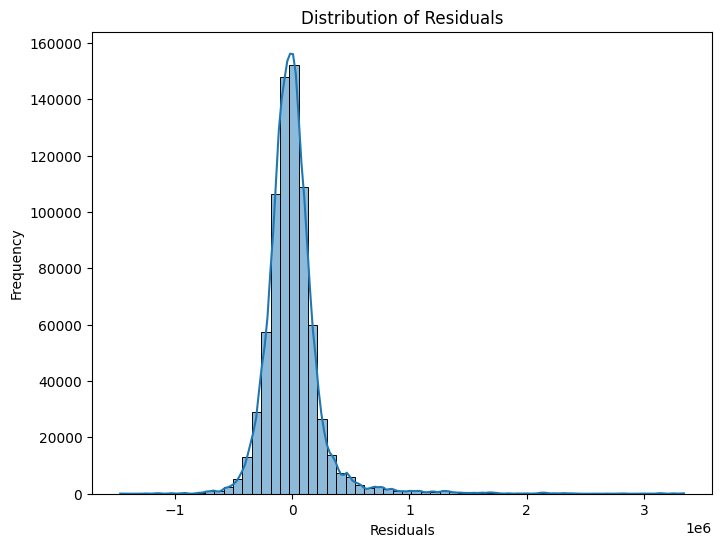

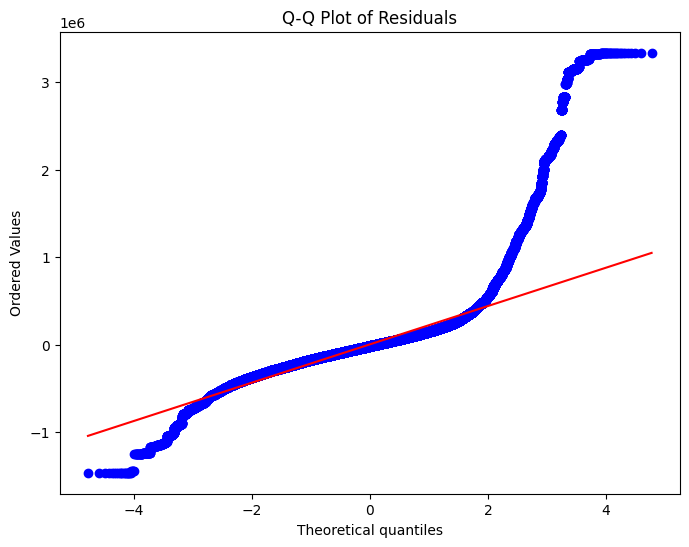

Best configuration:
Noise N: 0.01, Noise M: 0.1, Alpha: 0.01, Best R² Score: 0.6957298254445554


In [16]:
# models directory exists
os.makedirs("models", exist_ok=True)

results = []
actual_prices_list = []
predicted_prices_list = []
noise_n_list = []
noise_m_list = []
alpha_list = []
r2_scores = []

# initialize tracking variables
best_r2_test = float('-inf')  # Start with a very low value
best_model_filename = "models/ridge_model.pkl"
best_noise_n, best_noise_m, best_alpha = None, None, None  # best parameters

# alpha values for Ridge Regression
alpha_values = [0.01, 0.1, 1, 10, 100]

for noise_n in [0.01, 0.05, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for noise_m in [0.1, 0.2, 0.3, 0.4, 0.5]:
        for alpha in alpha_values:
            # run the model pipeline with different values of noise and alpha
            result = run_model_pipeline(df, noise_n, noise_m, alpha, 'price')

            # Extract R² score
            current_r2_test = result["best_r2_test"]

            # if this model has the best R² score, save it
            if current_r2_test > best_r2_test:
                best_r2_test = current_r2_test
                best_noise_n, best_noise_m, best_alpha = noise_n, noise_m, alpha 

                # save the best trained model using pickle
                with open(best_model_filename, "wb") as model_file:
                    pickle.dump(result, model_file)

            # extract test set actual prices and predictions
            actual_prices = result["y_test_actual"]
            predicted_prices = result["test_predictions"]

            # append individual values to lists
            actual_prices_list.extend(actual_prices)
            predicted_prices_list.extend(predicted_prices)
            noise_n_list.extend([noise_n] * len(actual_prices))
            noise_m_list.extend([noise_m] * len(actual_prices))
            alpha_list.extend([alpha] * len(actual_prices))
            r2_scores.extend([current_r2_test] * len(actual_prices))

# create a proper long-format DataFrame
results_df = pd.DataFrame({
    "noise_n": noise_n_list,
    "noise_m": noise_m_list,
    "alpha": alpha_list,
    "best_r2_test": r2_scores,
    "Actual Price": actual_prices_list,
    "Predicted Price": predicted_prices_list,
    "Difference": [a - p for a, p in zip(actual_prices_list, predicted_prices_list)]
})

# load the best trained model from the saved pickle file
with open(best_model_filename, "rb") as model_file:
    final_model = pickle.load(model_file)

# call the external function
model_validation(results_df, final_model)

print("Best configuration:")
print(f"Noise N: {best_noise_n}, Noise M: {best_noise_m}, Alpha: {best_alpha}, Best R² Score: {best_r2_test}")


![ChessUrl](https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExYXdqbzYyYXdjd2dzMDVxMTJ5cXptNGVkNG5oNWU0a2piYTEyb3o3dyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/8LyveOHlPsuNW/giphy.gif "pickle")


### The End.